In [22]:
import matplotlib.pyplot as plt
import numpy as np

from schelling.plot import plot_agents

In [23]:
class Citizen:
    def __init__(self, id: int, type: int, coordinates: tuple[int, int], threshold: float = 0.65, satisfaction: float = 0.0):
        self.id = id
        self.type = type
        self.coordinates = coordinates
        self.threshold = threshold
        self.satisfaction = satisfaction

    def calculate_satisfaction(self, grid: np.ndarray, coordinates: tuple[int, int]):
        row, col = coordinates

        # Calculate the neighbors
        start_row = row - 1 if row > 0 else 0
        end_row = row + 2 if row < grid.shape[0] - 1 else grid.shape[0]
        start_col = col - 1 if col > 0 else 0
        end_col = col + 2 if col < grid.shape[1] - 1 else grid.shape[1]
        neighbors = grid[start_row:end_row, start_col:end_col]

        # Calculate the number of same color neighbors
        same_color_neighbors: int = np.sum(np.where(neighbors == self.type, 1, 0)) 

        # Calculate the number of empty neighbors
        empty_neighbors: int = np.sum(np.where(neighbors == 0, 1, 0)) -1

        # Calculate the number of different color neighbors
        different_color_neighbors: int = int(np.sum(np.where(neighbors != self.type, 1, 0)) - empty_neighbors)

        # Calculate the satisfaction
        if same_color_neighbors == 0 and different_color_neighbors == 0:
            self.satisfaction = 0
            

        self.satisfaction = same_color_neighbors/(same_color_neighbors + different_color_neighbors)

    def happy(self) -> bool:
        # Check if the citizen is happy
        if self.satisfaction >= self.threshold:
            return True
        
        return False


In [24]:
class City:
    def __init__(self, size: int, population: int, ratio: float):
        self.size = size
        self.total = size*size
        self.population = population
        self.ratio = ratio
        self.grid = self._generate_grid()

    def _generate_grid(self) -> np.ndarray:
        probabilities = [self.population/self.total*self.ratio, self.population/self.total*(1-self.ratio), 1-self.population/self.total]
        grid = np.random.choice([1, -1, 0], self.total, p=probabilities)
        return grid.reshape((self.size, self.size))

    def update_grid(self, old_location: tuple[int, int], new_location: tuple[int, int], type: int):
        self.grid[old_location] = 0
        self.grid[new_location] = type

In [25]:
def get_citizens_from_city(grid: np.ndarray, row: int, col: int) -> Citizen:
    id = row * grid.shape[1] + col
    type = grid[row, col]
    coordinates = (row, col)
    citizen = Citizen(id, type, coordinates)
    citizen.calculate_satisfaction(grid, (row, col))
    return citizen

def get_empty_locations(grid: np.ndarray) -> np.ndarray:
    rng = np.random.default_rng()
    empty_locations = np.argwhere(grid == 0)
    rng.shuffle(empty_locations)
    return empty_locations.tolist()

def update_satisfactions(citizens: list[Citizen], grid: np.ndarray) -> list[Citizen]:
    for citizen in citizens:
        citizen.happy(grid, citizen.coordinates)
    return citizens

def calculate_satisfaction(city: City) -> float:
    citizens = [get_citizens_from_city(city.grid, row, col) for row in range(city.size) for col in range(city.size) if city.grid[row, col] != 0]
    satisfaction = 0
    for citizen in citizens:
        citizen.calculate_satisfaction(city.grid, citizen.coordinates)
        satisfaction += citizen.satisfaction
    return satisfaction / len(citizens)


In [26]:
def move_citizen(citizen: Citizen, city: City, ) -> Citizen:
    virtual_citizen = Citizen(citizen.id, citizen.type, citizen.coordinates, citizen.threshold)
    empty_locations = get_empty_locations(city.grid)

    while empty_locations:
        # Get a random empty location
        new_location = empty_locations.pop()
        # Update the satisfaction
        virtual_citizen.calculate_satisfaction(city.grid, new_location)
        #if virtual_citizen.happy():
        if virtual_citizen.satisfaction > citizen.satisfaction:
            # Update the grid
            city.update_grid(virtual_citizen.coordinates, (new_location[0], new_location[1]), virtual_citizen.type)
            #print(f"Moving citizen {virtual_citizen.id} from {virtual_citizen.coordinates} to {new_location}")
            return city    
    return city    


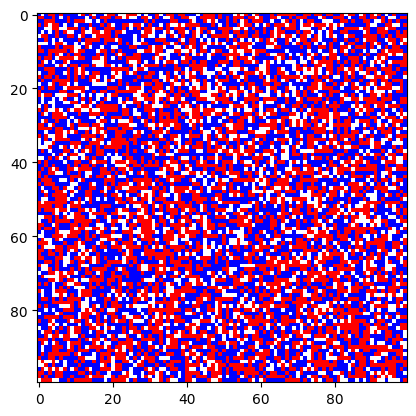

In [29]:
size = 100
population = size*size*0.8
ratio = 0.5
bcn = City(size, population, ratio)
plot_agents(bcn.grid)


for i in range(15):
    citizens = [get_citizens_from_city(bcn.grid, row, col) for row in range(size) for col in range(size) if bcn.grid[row, col] != 0]
    
    for citizen in citizens:
        if citizen.satisfaction < citizen.threshold:
            bcn = move_citizen(citizen, bcn)
    if i % 1 == 0:
        overall_satisfaction = calculate_satisfaction(bcn)
        print(f"Overall satisfaction {overall_satisfaction}")
        print(f"Iteration: {i}")
        plot_agents(bcn.grid)

In [28]:
np.count_nonzero(bcn.grid==0)

2066